In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# Airlines Data

# 1 - Business Problem

Forecast the airlines data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting

# 2 - Data collection and description

In [142]:
df = pd.read_excel("Airlines+Data.xlsx")

In [143]:
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [144]:
df1 = df.copy()

In [145]:
df1.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


# EDA

In [146]:
df1.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [147]:
df1.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [148]:

df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [149]:
df1 = df1.set_index('Month')

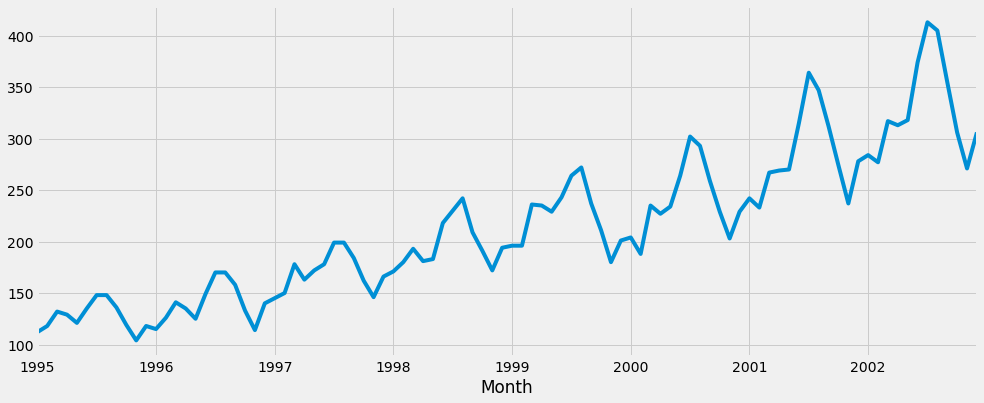

In [150]:
df1['Passengers'].plot(figsize=(15, 6))
plt.show()

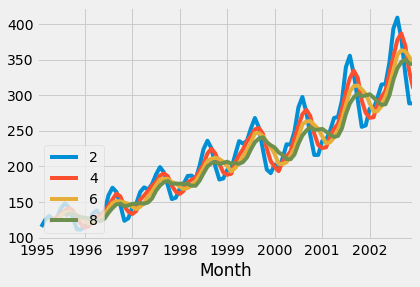

In [151]:

for i in range(2,10,2):
    df1['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

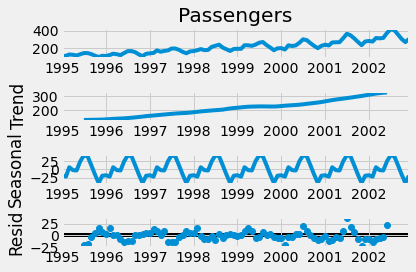

In [152]:
ts_add = seasonal_decompose(df1['Passengers'],model="additive")
fig = ts_add.plot()
plt.show()

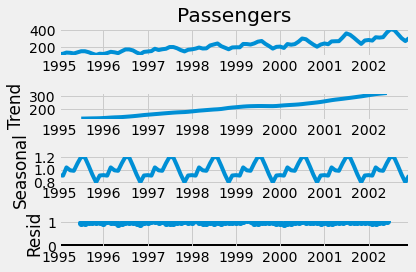

In [153]:
ts_mul = seasonal_decompose(df1.Passengers,model="multiplicative")
fig = ts_mul.plot()
plt.show()

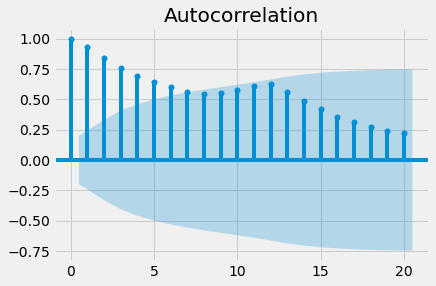

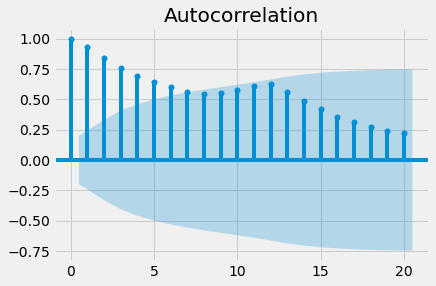

In [154]:
tsa_plots.plot_acf(df1['Passengers'])

# Checking the stationarity of the data

In [156]:
# finding the rolling mean and std
mean = df1.rolling(window=12).mean() 
std = df1.rolling(window=12).std()

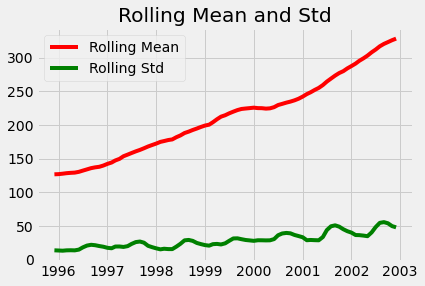

In [157]:
#Plot rolling statistics
mean = plt.plot(mean, color='red', label='Rolling Mean')
std = plt.plot(std, color='green', label='Rolling Std')
# labeling the axis
plt.legend(loc='best')
plt.title('Rolling Mean and Std')
plt.show()

The standard deviation is nearly constant but the mean is not constant which means the time series is non stationary

# Log transformation

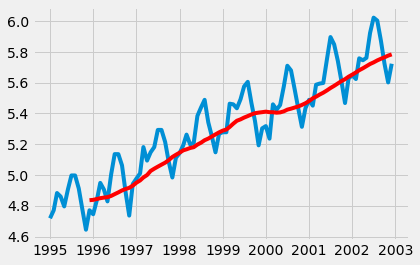

In [168]:
#Applying the log transformation on Closing price

logScale = np.log(df1['Passengers'])
#TFinding the average and std
moving_Average = logScale.rolling(window=12).mean()
moving_STD = logScale.rolling(window=12).std()
# plotting the graph
plt.plot(logScale)
plt.plot(moving_Average, color='red')
plt.show()

In [169]:
# transforming the time series
log_transformed = logScale - moving_Average
#Remove NAN values
log_transformed.dropna(inplace=True)
# printing heading of dataset
log_transformed.head()

Month
1995-12-01   -0.065494
1996-01-01   -0.093449
1996-02-01   -0.007566
1996-03-01    0.099416
1996-04-01    0.052142
Name: Passengers, dtype: float64

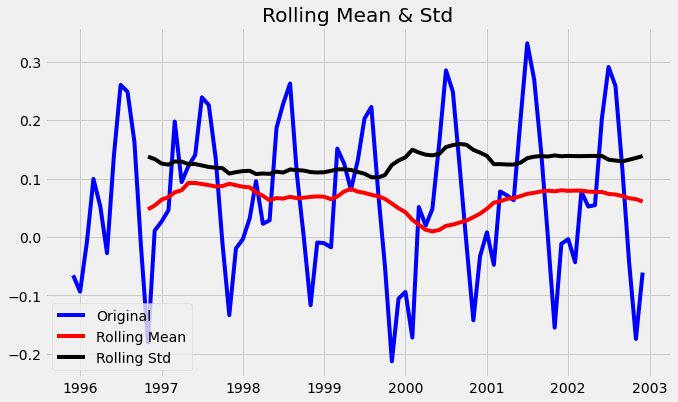

In [170]:
# fixing the size of image
plt.figure(figsize=[10, 6])
# finding the rolling mean and std
movingAverage = log_transformed.rolling(window=12).mean()
movingSTD = log_transformed.rolling(window=12).std()
    
# plotting graph and meaa and std
orig = plt.plot(log_transformed, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
# plotting stationary time series data
plt.legend(loc='best')
plt.title('Rolling Mean & Std')
plt.show()

In [173]:
from statsmodels.tsa.stattools import adfuller
#X = log_transformed.Passengers
result = adfuller(log_transformed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.910930
p-value: 0.326937
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


# TimeShift Tranformation

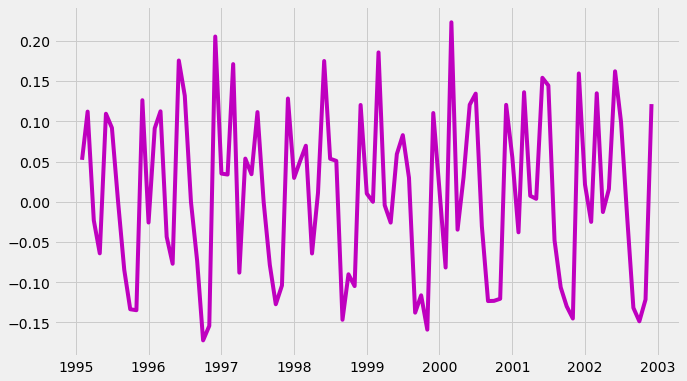

In [174]:
# fixing the size of image
plt.figure(figsize=[10, 6])
#  applynig timeshift transformation
Shifting = logScale - logScale.shift()
# plotting the timeshif 
plt.plot(Shifting , c='m')
# showing the timeshift
plt.show()

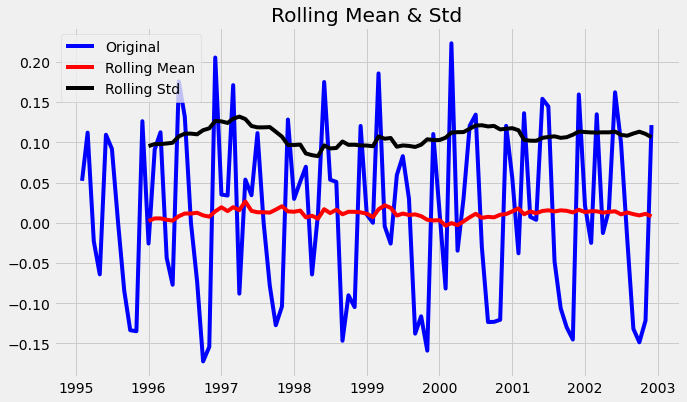

In [175]:
# fixing the size of image
plt.figure(figsize=[10, 6])
#rolling mean of timeshift transformed data
moving_Average = Shifting.rolling(window=12).mean()
# rolling std of timeshift transformed data
moving_STD = Shifting.rolling(window=12).std()
    
#plotting the original data
orig = plt.plot(Shifting, color='blue', label='Original')
# plotting the mean and std of transformed data
mean = plt.plot(moving_Average, color='red', label='Rolling Mean')
std = plt.plot(moving_STD, color='black', label='Rolling Std')
# Labeling
plt.legend(loc='best')
plt.title('Rolling Mean & Std')
plt.show()

In [181]:
logScale

Month
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791
                ...   
2002-08-01    6.003887
2002-09-01    5.872118
2002-10-01    5.723585
2002-11-01    5.602119
2002-12-01    5.723585
Name: Passengers, Length: 96, dtype: float64

In [183]:
from statsmodels.tsa.stattools import adfuller
#X = log_transformed.Passengers
result = adfuller(Shifting[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.670823
p-value: 0.079225
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


# Our Series is now stationary for AR Forecasting

# 3 - Building Time series forecasting with ARIMA

In [189]:
X =Shifting[1:]

In [190]:

size = int(len(X) * 0.66)

In [191]:
train, test = X[0:size], X[size:len(X)]

In [192]:
model = ARIMA(train, order=(5,1,0))

In [193]:
model_fit = model.fit(disp=0)

In [194]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                   61
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  48.955
Method:                       css-mle   S.D. of innovations              0.107
Date:                Fri, 11 Nov 2022   AIC                            -83.911
Time:                        14:29:37   BIC                            -69.135
Sample:                    03-01-1995   HQIC                           -78.120
                         - 03-01-2000                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0003      0.004     -0.075      0.940      -0.008       0.008
ar.L1.D.Passengers    -0.6534      0.129     -5.052      0.000      -0.907      -0.400
ar.L2.D.Passengers  

# This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

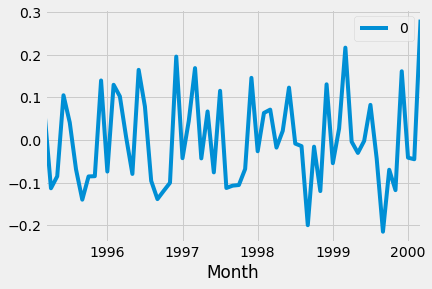

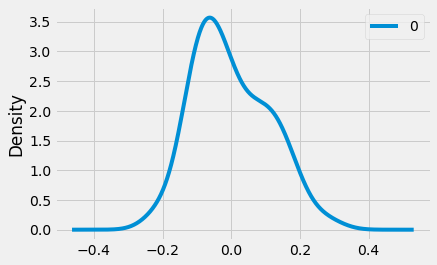

               0
count  61.000000
mean   -0.000221
std     0.108770
min    -0.215062
25%    -0.084774
50%    -0.017692
75%     0.078767
max     0.282674


In [195]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

The plot of the residual errors suggests that there may still be some trend information not captured by the model

The results show that there is no a bias in the prediction (a zero mean in the residuals)

# 3.1 - Rolling Forecast ARIMA Model

In [196]:

history = [x for x in train]

In [197]:
predictions = list()

In [198]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=-0.009740, expected=-0.034635
predicted=-0.037863, expected=0.030371
predicted=0.089657, expected=0.120628
predicted=-0.010218, expected=0.134478
predicted=0.093931, expected=-0.030254
predicted=0.079072, expected=-0.123345
predicted=-0.034305, expected=-0.123106
predicted=-0.029217, expected=-0.120516
predicted=-0.010323, expected=0.120516
predicted=0.059321, expected=0.055216
predicted=-0.025289, expected=-0.037899
predicted=-0.055544, expected=0.136210
predicted=-0.015994, expected=0.007463
predicted=-0.005885, expected=0.003711
predicted=0.073370, expected=0.154151
predicted=0.050356, expected=0.144581
predicted=0.084198, expected=-0.047829
predicted=0.054759, expected=-0.106322
predicted=-0.026980, expected=-0.129875
predicted=-0.040237, expected=-0.145068
predicted=-0.007786, expected=0.159561
predicted=0.080514, expected=0.021353
predicted=-0.042282, expected=-0.024957
predicted=-0.033027, expected=0.134884
predicted=-0.035105, expected=-0.012699
predicted=-0.011722, e

In [199]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.012


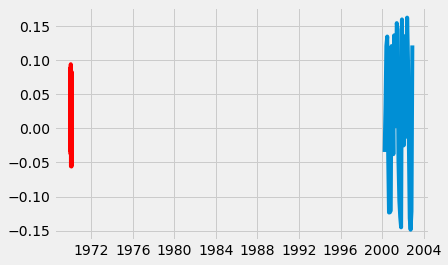

In [200]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). 

We can see the values show some trend and are in the correct scale

# 4 - Comparing Multiple Models

In [201]:

df2 = df.copy()

In [202]:
df2

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [203]:
df2 = pd.get_dummies(df2, columns = ['Month'])

In [204]:
df2.head()

,Passengers,Month_1995-01-01 00:00:00,Month_1995-02-01 00:00:00,Month_1995-03-01 00:00:00,Month_1995-04-01 00:00:00,Month_1995-05-01 00:00:00,Month_1995-06-01 00:00:00,Month_1995-07-01 00:00:00,Month_1995-08-01 00:00:00,Month_1995-09-01 00:00:00,...,Month_2002-03-01 00:00:00,Month_2002-04-01 00:00:00,Month_2002-05-01 00:00:00,Month_2002-06-01 00:00:00,Month_2002-07-01 00:00:00,Month_2002-08-01 00:00:00,Month_2002-09-01 00:00:00,Month_2002-10-01 00:00:00,Month_2002-11-01 00:00:00,Month_2002-12-01 00:00:00
0,112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,132,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,121,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
str1="Month_"
li=["Passengers"]
for i in range(1,97):
    str2=str1+str(i)
    li.append(str2)

df2.columns=li
df2

,Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Month_87,Month_88,Month_89,Month_90,Month_91,Month_92,Month_93,Month_94,Month_95,Month_96
0,112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,132,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,121,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,405,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
92,355,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
93,306,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
94,271,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [206]:
df2.shape

(96, 97)

In [207]:
t= np.arange(1,97)

In [208]:
df2['t'] = t

In [209]:

df2['t_sq'] = df2['t']*df2['t']

In [210]:
log_Passengers=np.log(df2['Passengers'])

In [211]:
df2['log_Passengers']=log_Passengers

In [212]:
df2.head()

,Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Month_90,Month_91,Month_92,Month_93,Month_94,Month_95,Month_96,t,t_sq,log_Passengers
0,112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4.718499
1,118,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,4.770685
2,132,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,4.882802
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,4.859812
4,121,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,25,4.795791


In [213]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [214]:
test1

,Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Month_90,Month_91,Month_92,Month_93,Month_94,Month_95,Month_96,t,t_sq,log_Passengers
64,234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,65,4225,5.455321
65,264,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,66,4356,5.575949
66,302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,67,4489,5.710427
67,293,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,4624,5.680173
68,259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,69,4761,5.556828
69,229,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,70,4900,5.433722
70,203,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,71,5041,5.313206
71,229,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,72,5184,5.433722
72,242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,73,5329,5.488938
73,233,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,74,5476,5.451038


In [215]:
linear= smf.ols('Passengers ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Passengers'])-np.array(predlin))**2))
rmselin

25.503983516483537

In [216]:

quad=smf.ols('Passengers~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predquad))**2))
rmsequad

53.18955514415421

In [217]:
expo=smf.ols('Passengers~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predexp)))**2))
rmseexpo

1.603094593327857e+128

In [218]:
s = df2.columns
str1=""
s2 = s[1:97]
for i in s[1:97]:
    str1=str1+"+"+i
result="Passengers~"+str1
print(result)

Passengers~+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12+Month_13+Month_14+Month_15+Month_16+Month_17+Month_18+Month_19+Month_20+Month_21+Month_22+Month_23+Month_24+Month_25+Month_26+Month_27+Month_28+Month_29+Month_30+Month_31+Month_32+Month_33+Month_34+Month_35+Month_36+Month_37+Month_38+Month_39+Month_40+Month_41+Month_42+Month_43+Month_44+Month_45+Month_46+Month_47+Month_48+Month_49+Month_50+Month_51+Month_52+Month_53+Month_54+Month_55+Month_56+Month_57+Month_58+Month_59+Month_60+Month_61+Month_62+Month_63+Month_64+Month_65+Month_66+Month_67+Month_68+Month_69+Month_70+Month_71+Month_72+Month_73+Month_74+Month_75+Month_76+Month_77+Month_78+Month_79+Month_80+Month_81+Month_82+Month_83+Month_84+Month_85+Month_86+Month_87+Month_88+Month_89+Month_90+Month_91+Month_92+Month_93+Month_94+Month_95+Month_96


In [219]:
result2="log_Passengers~"+str1
print(result2)

log_Passengers~+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12+Month_13+Month_14+Month_15+Month_16+Month_17+Month_18+Month_19+Month_20+Month_21+Month_22+Month_23+Month_24+Month_25+Month_26+Month_27+Month_28+Month_29+Month_30+Month_31+Month_32+Month_33+Month_34+Month_35+Month_36+Month_37+Month_38+Month_39+Month_40+Month_41+Month_42+Month_43+Month_44+Month_45+Month_46+Month_47+Month_48+Month_49+Month_50+Month_51+Month_52+Month_53+Month_54+Month_55+Month_56+Month_57+Month_58+Month_59+Month_60+Month_61+Month_62+Month_63+Month_64+Month_65+Month_66+Month_67+Month_68+Month_69+Month_70+Month_71+Month_72+Month_73+Month_74+Month_75+Month_76+Month_77+Month_78+Month_79+Month_80+Month_81+Month_82+Month_83+Month_84+Month_85+Month_86+Month_87+Month_88+Month_89+Month_90+Month_91+Month_92+Month_93+Month_94+Month_95+Month_96


In [220]:
additive= smf.ols(result,data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[s2])))
rmseadd=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predadd))**2))
rmseadd

131.09608478801178

In [221]:
addlinear= smf.ols(result,data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[s2])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predaddlinear))**2))
rmseaddlinear

131.09608478801178

In [222]:
addquad=smf.ols(result,data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[s2])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predaddquad))**2))
rmseaddquad

131.09608478801178

In [223]:
mulsea=smf.ols(result2,data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[s2])))
rmsemul= np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predmul)))**2))
rmsemul

145.15906210015228

In [224]:
result3="log_Passengers~t"+str1
print(result3)

log_Passengers~t+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12+Month_13+Month_14+Month_15+Month_16+Month_17+Month_18+Month_19+Month_20+Month_21+Month_22+Month_23+Month_24+Month_25+Month_26+Month_27+Month_28+Month_29+Month_30+Month_31+Month_32+Month_33+Month_34+Month_35+Month_36+Month_37+Month_38+Month_39+Month_40+Month_41+Month_42+Month_43+Month_44+Month_45+Month_46+Month_47+Month_48+Month_49+Month_50+Month_51+Month_52+Month_53+Month_54+Month_55+Month_56+Month_57+Month_58+Month_59+Month_60+Month_61+Month_62+Month_63+Month_64+Month_65+Month_66+Month_67+Month_68+Month_69+Month_70+Month_71+Month_72+Month_73+Month_74+Month_75+Month_76+Month_77+Month_78+Month_79+Month_80+Month_81+Month_82+Month_83+Month_84+Month_85+Month_86+Month_87+Month_88+Month_89+Month_90+Month_91+Month_92+Month_93+Month_94+Month_95+Month_96


In [225]:
str2=""
s2 = s[1:98]
for i in s[1:98]:
    str2=str2+"+"+i
str2=str2[1:]
print(str2)

Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12+Month_13+Month_14+Month_15+Month_16+Month_17+Month_18+Month_19+Month_20+Month_21+Month_22+Month_23+Month_24+Month_25+Month_26+Month_27+Month_28+Month_29+Month_30+Month_31+Month_32+Month_33+Month_34+Month_35+Month_36+Month_37+Month_38+Month_39+Month_40+Month_41+Month_42+Month_43+Month_44+Month_45+Month_46+Month_47+Month_48+Month_49+Month_50+Month_51+Month_52+Month_53+Month_54+Month_55+Month_56+Month_57+Month_58+Month_59+Month_60+Month_61+Month_62+Month_63+Month_64+Month_65+Month_66+Month_67+Month_68+Month_69+Month_70+Month_71+Month_72+Month_73+Month_74+Month_75+Month_76+Month_77+Month_78+Month_79+Month_80+Month_81+Month_82+Month_83+Month_84+Month_85+Month_86+Month_87+Month_88+Month_89+Month_90+Month_91+Month_92+Month_93+Month_94+Month_95+Month_96+t


In [226]:
mullin= smf.ols(result3,data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[s2])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predmullin)))**2))
rmsemulin

101.57163926539772

In [227]:
result4="log_Passengers~t+t_sq"+str1
print(result4)

log_Passengers~t+t_sq+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12+Month_13+Month_14+Month_15+Month_16+Month_17+Month_18+Month_19+Month_20+Month_21+Month_22+Month_23+Month_24+Month_25+Month_26+Month_27+Month_28+Month_29+Month_30+Month_31+Month_32+Month_33+Month_34+Month_35+Month_36+Month_37+Month_38+Month_39+Month_40+Month_41+Month_42+Month_43+Month_44+Month_45+Month_46+Month_47+Month_48+Month_49+Month_50+Month_51+Month_52+Month_53+Month_54+Month_55+Month_56+Month_57+Month_58+Month_59+Month_60+Month_61+Month_62+Month_63+Month_64+Month_65+Month_66+Month_67+Month_68+Month_69+Month_70+Month_71+Month_72+Month_73+Month_74+Month_75+Month_76+Month_77+Month_78+Month_79+Month_80+Month_81+Month_82+Month_83+Month_84+Month_85+Month_86+Month_87+Month_88+Month_89+Month_90+Month_91+Month_92+Month_93+Month_94+Month_95+Month_96


In [228]:
str3=""
s3 = s[1:99]
for i in s[1:99]:
    str3=str3+"+"+i
str3=str3[1:]
print(str3)
s3

Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12+Month_13+Month_14+Month_15+Month_16+Month_17+Month_18+Month_19+Month_20+Month_21+Month_22+Month_23+Month_24+Month_25+Month_26+Month_27+Month_28+Month_29+Month_30+Month_31+Month_32+Month_33+Month_34+Month_35+Month_36+Month_37+Month_38+Month_39+Month_40+Month_41+Month_42+Month_43+Month_44+Month_45+Month_46+Month_47+Month_48+Month_49+Month_50+Month_51+Month_52+Month_53+Month_54+Month_55+Month_56+Month_57+Month_58+Month_59+Month_60+Month_61+Month_62+Month_63+Month_64+Month_65+Month_66+Month_67+Month_68+Month_69+Month_70+Month_71+Month_72+Month_73+Month_74+Month_75+Month_76+Month_77+Month_78+Month_79+Month_80+Month_81+Month_82+Month_83+Month_84+Month_85+Month_86+Month_87+Month_88+Month_89+Month_90+Month_91+Month_92+Month_93+Month_94+Month_95+Month_96+t+t_sq


Index(['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Month_13', 'Month_14', 'Month_15', 'Month_16', 'Month_17', 'Month_18',
       'Month_19', 'Month_20', 'Month_21', 'Month_22', 'Month_23', 'Month_24',
       'Month_25', 'Month_26', 'Month_27', 'Month_28', 'Month_29', 'Month_30',
       'Month_31', 'Month_32', 'Month_33', 'Month_34', 'Month_35', 'Month_36',
       'Month_37', 'Month_38', 'Month_39', 'Month_40', 'Month_41', 'Month_42',
       'Month_43', 'Month_44', 'Month_45', 'Month_46', 'Month_47', 'Month_48',
       'Month_49', 'Month_50', 'Month_51', 'Month_52', 'Month_53', 'Month_54',
       'Month_55', 'Month_56', 'Month_57', 'Month_58', 'Month_59', 'Month_60',
       'Month_61', 'Month_62', 'Month_63', 'Month_64', 'Month_65', 'Month_66',
       'Month_67', 'Month_68', 'Month_69', 'Month_70', 'Month_71', 'Month_72',
       'Month_73', 'Month_74', 'Month_75', 'Month_76', 'Month

In [229]:

mul_quad= smf.ols(result4,data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[s3]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

185.40106517638898

# 5 - Conclusion

In [230]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [231]:
rmse=pd.DataFrame(output)

In [232]:
print(rmse)

           Model         Values
0  rmse_mul_quad   1.854011e+02
1        rmseadd   1.310961e+02
2  rmseaddlinear   1.310961e+02
3    rmseaddquad   1.310961e+02
4       rmseexpo  1.603095e+128
5        rmselin   2.550398e+01
6        rmsemul   1.451591e+02
7      rmsemulin   1.015716e+02
8       rmsequad   5.318956e+01


# Multiplicative seasonality with linear trend has the best RMSE value

# Cococola Data

# 1 - Business Problem

Forecast the airlines data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting



# 2 - Data collection and description

In [233]:
df = pd.read_excel(r"CocaCola_Sales_Rawdata.xlsx")

In [234]:
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [235]:
df1 = df.copy()

In [236]:
df1.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


# EDA

In [237]:
df1.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [238]:
df1.dtypes

Quarter     object
Sales      float64
dtype: object

In [239]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [240]:
temp = df1.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

In [241]:
df1['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')

In [242]:
df1.head()

,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [243]:
df1 = df1.drop(['Quarter'], axis=1)

In [244]:
df1.reset_index(inplace=True)

In [245]:
df1['quater'] = pd.to_datetime(df1['quater'])

In [246]:
df1 = df1.set_index('quater')

In [247]:
df1.head()

,index,Sales
quater,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993
1986-10-01,3,2154.962997
1987-01-01,4,1547.818996


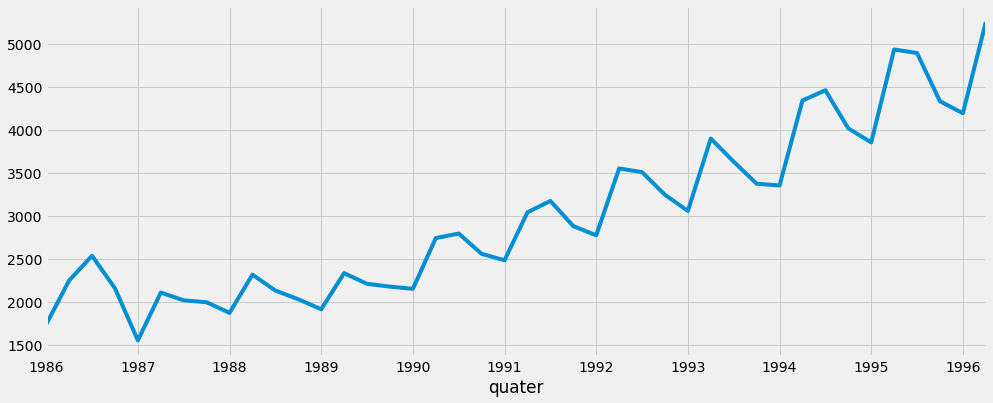

In [248]:
df1['Sales'].plot(figsize=(15, 6))
plt.show()

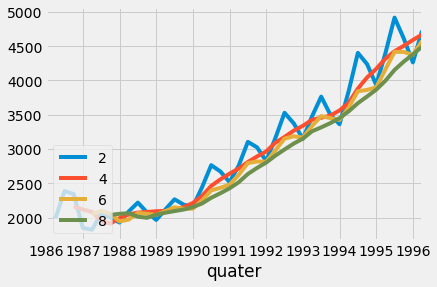

In [249]:
for i in range(2,10,2):
    df1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

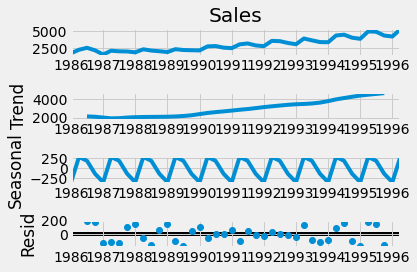

In [250]:
ts_add = seasonal_decompose(df1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

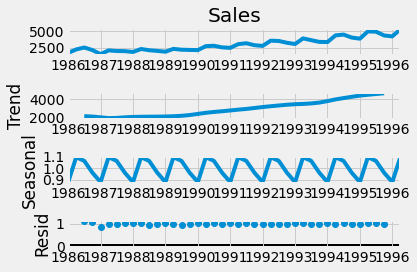

In [251]:
ts_mul = seasonal_decompose(df1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

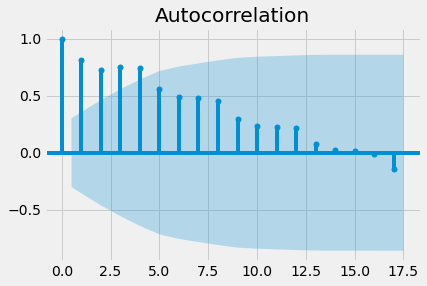

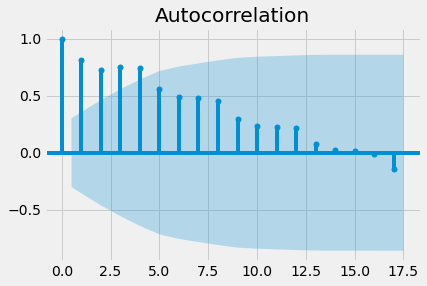

In [252]:
tsa_plots.plot_acf(df1.Sales)

# Checking the stationarity of the data

In [253]:
# finding the rolling mean and std
mean = df1.rolling(window=12).mean() 
std = df1.rolling(window=12).std()

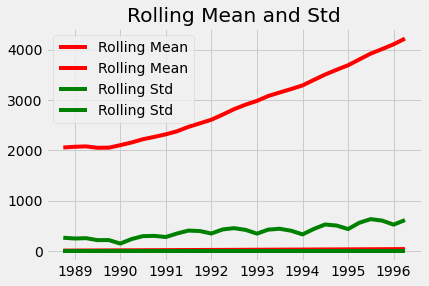

In [254]:
#Plot rolling statistics
mean = plt.plot(mean, color='red', label='Rolling Mean')
std = plt.plot(std, color='green', label='Rolling Std')
# labeling the axis
plt.legend(loc='best')
plt.title('Rolling Mean and Std')
plt.show()

The standard deviation is nearly constant but the mean is not constant which means the time series is non stationary

# Log transformation

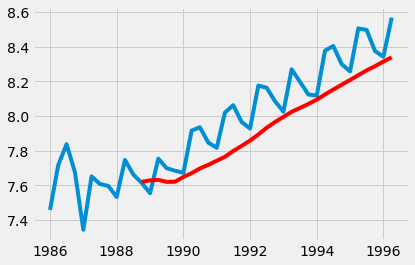

In [255]:
#Applying the log transformation on Closing price

logScale = np.log(df1['Sales'])
#TFinding the average and std
moving_Average = logScale.rolling(window=12).mean()
moving_STD = logScale.rolling(window=12).std()
# plotting the graph
plt.plot(logScale)
plt.plot(moving_Average, color='red')
plt.show()

In [256]:
# transforming the time series
log_transformed = logScale - moving_Average
#Remove NAN values
log_transformed.dropna(inplace=True)
# printing heading of dataset
log_transformed.head()


quater
1988-10-01   -0.006306
1989-01-01   -0.073402
1989-04-01    0.122407
1989-07-01    0.078993
1989-10-01    0.063385
Name: Sales, dtype: float64

In [260]:

# fixing the size of image
plt.figure(figsize=[10, 8])
# finding the rolling mean and std
movingAverage = log_transformed.rolling(window=12).mean()
movingSTD = log_transformed.rolling(window=12).std()

<Figure size 720x576 with 0 Axes>

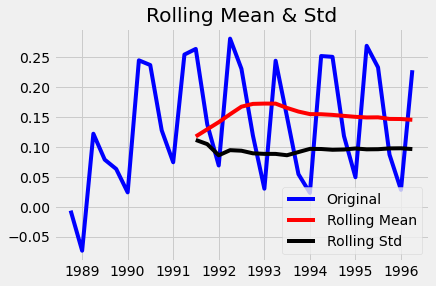

In [258]:
# plotting graph and meaa and std
orig = plt.plot(log_transformed, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
# plotting stationary time series data
plt.legend(loc='best')
plt.title('Rolling Mean & Std')
plt.show()

In [259]:

from statsmodels.tsa.stattools import adfuller
#X = log_transformed.Passengers
result = adfuller(log_transformed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.552128
p-value: 0.006745
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630


# TimeShift Tranformation

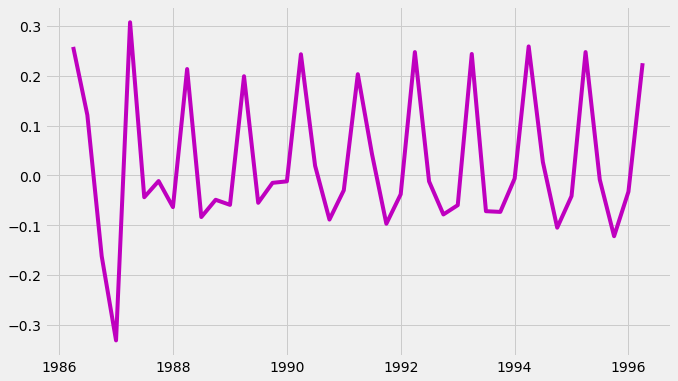

In [266]:
# fixing the size of image
plt.figure(figsize=[10, 6])
#  applynig timeshift transformation
Shifting = logScale - logScale.shift()
# plotting the timeshif 
plt.plot(Shifting , c='m')
# showing the timeshift
plt.show()

In [267]:

# fixing the size of image
plt.figure(figsize=[10, 6])
#rolling mean of timeshift transformed data
moving_Average = Shifting.rolling(window=12).mean()
# rolling std of timeshift transformed data
moving_STD = Shifting.rolling(window=12).std()

<Figure size 720x432 with 0 Axes>

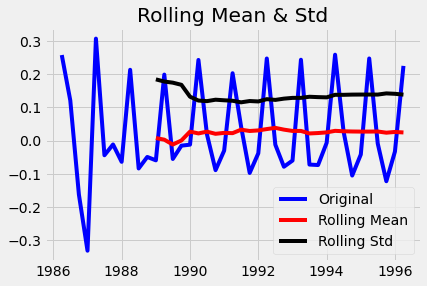

In [268]:
#plotting the original data
orig = plt.plot(Shifting, color='blue', label='Original')
# plotting the mean and std of transformed data
mean = plt.plot(moving_Average, color='red', label='Rolling Mean')
std = plt.plot(moving_STD, color='black', label='Rolling Std')
# Labeling
plt.legend(loc='best')
plt.title('Rolling Mean & Std')
plt.show()

In [269]:
from statsmodels.tsa.stattools import adfuller
#X = log_transformed.Passengers
result = adfuller(Shifting[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.190392
p-value: 0.020548
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614


# Our Series is now stationary for AR Forecasting

# 3 - Building Time series forecasting with ARIMA

In [270]:
X =Shifting[1:]

In [271]:
size = int(len(X) * 0.66)

In [272]:
train, test = X[0:size], X[size:len(X)]

In [273]:
model = ARIMA(train, order=(5,1,0))

In [274]:
model_fit = model.fit(disp=0)

In [275]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   26
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  27.707
Method:                       css-mle   S.D. of innovations              0.071
Date:                Fri, 11 Nov 2022   AIC                            -41.414
Time:                        14:41:02   BIC                            -32.607
Sample:                    07-01-1986   HQIC                           -38.878
                         - 10-01-1992                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0030      0.003      1.117      0.264      -0.002       0.008
ar.L1.D.Sales    -1.0801      0.187     -5.785      0.000      -1.446      -0.714
ar.L2.D.Sales    -1.4487      0.278     

This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

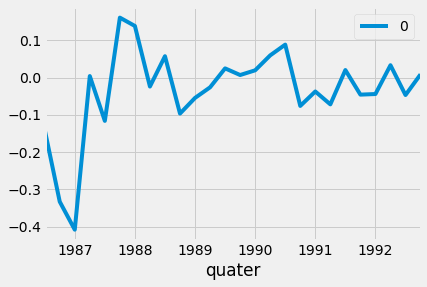

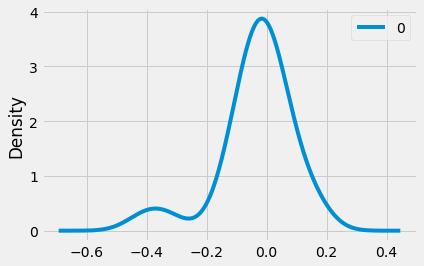

               0
count  26.000000
mean   -0.034690
std     0.122301
min    -0.408325
25%    -0.067698
50%    -0.025231
75%     0.023433
max     0.160745


In [276]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

The plot of the residual errors suggests that there may still be some trend information not captured by the model

The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)

# 3.1 - Rolling Forecast ARIMA Model

In [277]:
history = [x for x in train]

In [278]:
predictions = list()

In [279]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.030735, expected=-0.059657
predicted=0.239372, expected=0.243613
predicted=-0.007083, expected=-0.071763
predicted=-0.056774, expected=-0.073155
predicted=-0.000887, expected=-0.006245
predicted=0.229402, expected=0.258778
predicted=-0.097411, expected=0.027038
predicted=-0.059776, expected=-0.104838
predicted=0.001162, expected=-0.041424
predicted=0.272058, expected=0.247444
predicted=0.036569, expected=-0.008341
predicted=-0.084281, expected=-0.121954
predicted=0.003451, expected=-0.032605
predicted=0.247000, expected=0.225144


In [280]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.003


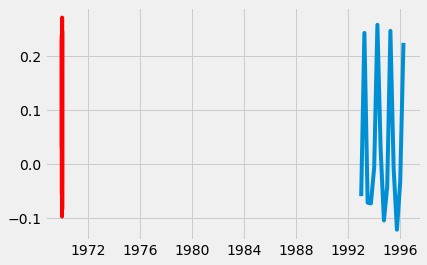

In [281]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale

# 4 - Comparing Multiple Models

In [282]:
df2 = pd.get_dummies(df, columns = ['Quarter'])

In [283]:
df2.columns = ['Sales','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4']


In [284]:
df2.head()

,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2154.962997,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [285]:
t= np.arange(1,43)

In [286]:

df2['t'] = t

In [287]:
df2['t_sq'] = df2['t']*df2['t']

In [288]:
log_Sales=np.log(df2['Sales'])

In [289]:
df2['log_Sales']=log_Sales

In [290]:
df2.head()

,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,t,t_sq,log_Sales
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7.458663
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,7.716443
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,7.837477
3,2154.962997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,7.675529
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,25,7.344602


In [291]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [292]:
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918641

In [293]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

783.7297975037103

In [294]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900134

In [295]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

1869.7188209186947

In [296]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

596.1526282372472

In [297]:
addquad=smf.ols('Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

412.1144436053775

In [298]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

2374.9194407954374

In [299]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

5359.687911932085

In [300]:
mul_quad= smf.ols('log_Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

3630.5619467347524

# 5 - Conclusion

In [301]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [302]:
rmse=pd.DataFrame(output)

In [303]:
print(rmse)

           Model       Values
0  rmse_mul_quad  3630.561947
1        rmseadd  1869.718821
2  rmseaddlinear   596.152628
3    rmseaddquad   412.114444
4       rmseexpo   588.140510
5        rmselin   580.122413
6        rmsemul  2374.919441
7      rmsemulin  5359.687912
8       rmsequad   783.729798


# Additive seasonality with quadratic trend has the best RMSE value